In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env BSD500_DATA_DIR=/home/zaccharie/workspace/understanding-unets/
%env BSD68_DATA_DIR=/home/zaccharie/workspace/understanding-unets/

env: BSD500_DATA_DIR=/home/zaccharie/workspace/understanding-unets/
env: BSD68_DATA_DIR=/home/zaccharie/workspace/understanding-unets/


In [3]:
%cd ..
from tdv import TDV
%cd experiments
from data import im_dataset_bsd500
from unrolled_fb import UnrolledFB

/home/zaccharie/workspace/tf-tdv
/home/zaccharie/workspace/tf-tdv/experiments


In [4]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tqdm.notebook import tqdm

In [5]:
train_ds = im_dataset_bsd500(batch_size=4)

In [6]:
model = UnrolledFB(TDV, {}, init_step_size=0.0001, n_iter=5)

In [7]:
%%time
data = next(iter(train_ds))

CPU times: user 97.4 ms, sys: 8.08 ms, total: 105 ms
Wall time: 69.8 ms


In [26]:
model(data[0]);

In [9]:
model.load_weights('denoising_unrolled_fb_tdv.h5')

In [10]:
sub_model = model.proxs[0]

We want to solve the following optim problem
\begin{equation*}
argmin_x argmax_{\lambda} R(x, \theta) - \frac{\lambda}{2} (\|x\|^2_2 - \|x_{init}\|^2_2)
\end{equation*}

In [27]:
x = tf.Variable(data[1][0:1], trainable=True, name='x')

@tf.function
def loss():
    # https://github.com/VLOGroup/tdv/blob/master/eigenfunctions.py
    grad_r = sub_model(x)
    lamda = tf.reduce_sum(grad_r * x, axis=[1, 2, 3], keepdims=True) / tf.reduce_sum(x**2, axis=[1, 2, 3], keepdims=True)
    diff = tf.reduce_mean((grad_r - lamda * x)**2)
    return diff

In [28]:
optimizer_x = SGD(learning_rate=5e-2)
n_iter = 1000
verbose = 1
losses = []
for i_iter in tqdm(range(n_iter)):
    optimizer_x.minimize(loss, [x])
    losses.append(loss())
    if verbose > 0 and i_iter % 10 == 0:
        print(i_iter, loss())

0 tf.Tensor(6.7329803, shape=(), dtype=float32)
10 tf.Tensor(3.7094226, shape=(), dtype=float32)
20 tf.Tensor(2.997996, shape=(), dtype=float32)
30 tf.Tensor(2.7023897, shape=(), dtype=float32)
40 tf.Tensor(2.4903278, shape=(), dtype=float32)
50 tf.Tensor(2.3592803, shape=(), dtype=float32)
60 tf.Tensor(2.2820132, shape=(), dtype=float32)
70 tf.Tensor(2.1656187, shape=(), dtype=float32)
80 tf.Tensor(2.102502, shape=(), dtype=float32)
90 tf.Tensor(2.043643, shape=(), dtype=float32)
100 tf.Tensor(1.9664904, shape=(), dtype=float32)
110 tf.Tensor(1.9260377, shape=(), dtype=float32)
120 tf.Tensor(1.8671069, shape=(), dtype=float32)
130 tf.Tensor(1.8227855, shape=(), dtype=float32)
140 tf.Tensor(1.7822967, shape=(), dtype=float32)
150 tf.Tensor(1.7608541, shape=(), dtype=float32)
160 tf.Tensor(1.7402583, shape=(), dtype=float32)
170 tf.Tensor(1.7004933, shape=(), dtype=float32)
180 tf.Tensor(1.6693069, shape=(), dtype=float32)
190 tf.Tensor(1.641677, shape=(), dtype=float32)
200 tf.Tensor(1

<IPython.core.display.Javascript object>


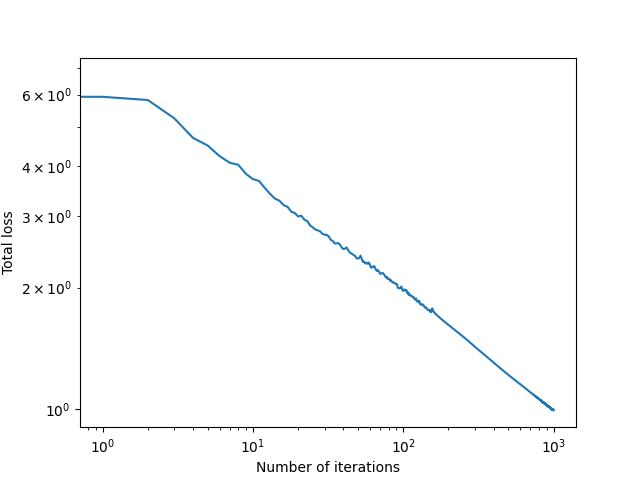

In [29]:
plt.figure()
plt.loglog(losses)
plt.xlabel('Number of iterations')
plt.ylabel('Total loss');

<IPython.core.display.Javascript object>


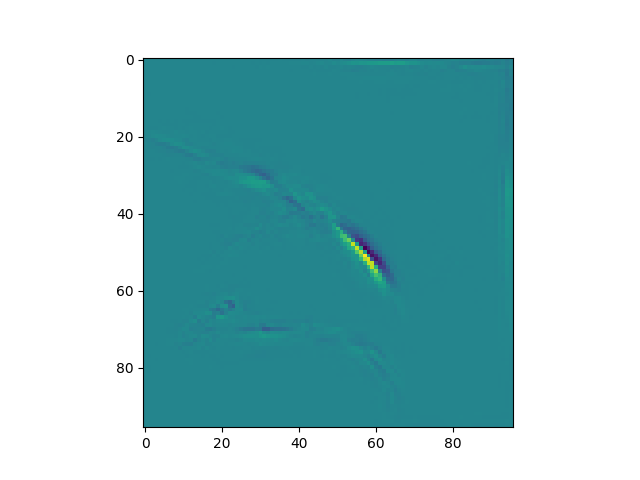

In [30]:
plt.figure()
plt.imshow(np.squeeze(x.numpy()))